In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-tweets-16m-tweets-with-sentiment-tagged/mbsa.csv
/kaggle/input/lid176bin/lid.176.bin


In [2]:
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from stop_words import get_stop_words
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re

In [3]:
tweets = pd.read_csv('/kaggle/input/bitcoin-tweets-16m-tweets-with-sentiment-tagged/mbsa.csv')
tweets.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [4]:
len(tweets)

19344048

In [5]:
from tqdm import tqdm

In [6]:
tweets = tweets.iloc[:,1:]
tweets.head()

,text,Sentiment
0,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,Another Test tweet that wasn't caught in the s...,Positive
3,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [7]:
tweets.Sentiment = tweets.Sentiment.apply(lambda x: str(x).lower())
tweets.Sentiment = tweets.Sentiment.map(lambda x: 1 if x=='positive' else 0)
tweets.head()

,text,Sentiment
0,È appena uscito un nuovo video! LES CRYPTOMONN...,1
1,Cardano: Digitize Currencies; EOS https://t.co...,1
2,Another Test tweet that wasn't caught in the s...,1
3,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,1
4,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,1


In [8]:
df = tweets.sample(1000000)

df.head()
print('Total Sample: ',len(df))
print(df.groupby(df.Sentiment).count())


Total Sample:  1000000
             text
Sentiment        
0          548311
1          451689


In [9]:
######## DATA CLEANING ########
stop_words = get_stop_words('english')
    
len(stop_words)

ps = PorterStemmer()
corpus = []
for i in df.text:
    new = re.sub('[^a-zA-z]', ' ',str(i))
    new = new.lower()
    new = nltk.word_tokenize(new)
    new = [ps.stem(i) for i in new if i not in stop_words]
    new = ' '.join(new)
    corpus.append(new)
    
df.text = corpus
df.head()

,text,Sentiment
10386803,epaz s bitcoin share amp blockchain social med...,0
7287624,btc bitcoin cryptocurr xrp bnb acnzqfzwpqk pcp...,1
9271016,bitmex btc whale worth bitcoin sold wait bounc...,1
7952520,riot call,1
174812,nkn btc hr ichimoku cloud twist ve bullish tk ...,0


In [10]:
########### Language Detection ###########

import fasttext

class LanguageDetector(object):
    def __init__(self, fname: str, label: str="__label__"):
        self._model = fasttext.load_model(fname)
        self.label = label
        
    def predict(self, text: str):
        prediction, probability = self._model.predict(text, k=1)
        
        prediction = prediction[0].replace(self.label, "")
        probability = probability[0]
        
        return prediction, probability

In [11]:
# model_fname = "../input/fasttextmodel/lid.176.ftz"
model_fname = "../input/lid176bin/lid.176.bin"

lang_detector = LanguageDetector(model_fname)
lang_detector.predict("this is a test")


('en', 0.9773516654968262)

In [12]:
def detect_language(text):
    lang, proba = lang_detector.predict(text)
    if proba > 0.67: # it was 0.5
        return lang
    else:
        return None

In [13]:
lang_detector.predict("ceci est un test de français")

('fr', 0.9961628317832947)

In [14]:
lang_detector.predict("esta es una prueba de frances")

('es', 0.9890584349632263)

In [15]:
lang_detector.predict("这是一个法语测试")

('zh', 1.0000574588775635)

In [16]:
for item in df:
    df["language"] = detect_language(item[0:])
print(item[:])
#     df["language"] = [detect_language(x) for x in df.text]
#     print(df.text)

print(df.language)
# df["language"] = df.text.apply(detect_language)
df.language.value_counts()

Sentiment
10386803    None
7287624     None
9271016     None
7952520     None
174812      None
            ... 
3600513     None
17892218    None
3205257     None
11582536    None
5649919     None
Name: language, Length: 1000000, dtype: object


Series([], Name: language, dtype: int64)

In [17]:
df.text.head()

10386803    epaz s bitcoin share amp blockchain social med...
7287624     btc bitcoin cryptocurr xrp bnb acnzqfzwpqk pcp...
9271016     bitmex btc whale worth bitcoin sold wait bounc...
7952520                                             riot call
174812      nkn btc hr ichimoku cloud twist ve bullish tk ...
Name: text, dtype: object

In [18]:
def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [19]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet_to_words(item)
    cleantext+=[words]
df['cleantext']=cleantext

100%|██████████| 1000000/1000000 [39:29<00:00, 421.98it/s]


In [20]:
df.head()

,text,Sentiment,language,cleantext
10386803,epaz s bitcoin share amp blockchain social med...,0,None,"[epaz, bitcoin, share, amp, blockchain, social..."
7287624,btc bitcoin cryptocurr xrp bnb acnzqfzwpqk pcp...,1,None,"[btc, bitcoin, cryptocurr, xrp, bnb, acnzqfzwp..."
9271016,bitmex btc whale worth bitcoin sold wait bounc...,1,None,"[bitmex, btc, whale, worth, bitcoin, sold, wai..."
7952520,riot call,1,None,"[riot, call]"
174812,nkn btc hr ichimoku cloud twist ve bullish tk ...,0,None,"[nkn, btc, hr, ichimoku, cloud, twist, bullish..."


In [21]:
############## It Takes long time #############

uniqwords=[]
for sent_item in tqdm(df['cleantext']):
    for words_of_sent in sent_item:
        if words_of_sent not in uniqwords: uniqwords += [words_of_sent]
         
            
print(len(uniqwords))

100%|██████████| 1000000/1000000 [5:44:53<00:00, 48.32it/s]

767226


In [22]:
################################################################
########################## Parameters ########################
################################################################

# vocab_size = 20000  # Only consider the top 20k words
vocab_size = 40000  # Only consider the top 40k words
epochs = 30
n_heads = 6   #Or 3
# maxlen = 200
maxlen = 32 # max_length was 64

################################################################

In [23]:
print(df)

                                                       text  Sentiment  \
10386803  epaz s bitcoin share amp blockchain social med...          0   
7287624   btc bitcoin cryptocurr xrp bnb acnzqfzwpqk pcp...          1   
9271016   bitmex btc whale worth bitcoin sold wait bounc...          1   
7952520                                           riot call          1   
174812    nkn btc hr ichimoku cloud twist ve bullish tk ...          0   
...                                                     ...        ...   
3600513                                          lifeoncoin          0   
17892218           thank guy great web http t co iusl aw tz          1   
3205257                                       btc_infochain          0   
11582536                                          kingjoeyi          0   
5649919   order secur smart btc eth altcoin hardwar wall...          0   

         language                                          cleantext  
10386803     None  [epaz, bitcoin, share

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense,Flatten
from tensorflow.keras.models import Sequential, Model
from keras.layers import Conv1D,MaxPooling1D

In [25]:
class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model,)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.convnet=Sequential(
            [Conv1D(d_model,10,1,padding='same', activation='relu'),MaxPooling1D(4,1,padding='same'),
            Conv1D(d_model,8,1,padding='same', activation='relu'),MaxPooling1D(2,1,padding='same'),
            Conv1D(d_model,6,1,padding='same', activation='relu'),MaxPooling1D(2,1,padding='same'),])
#adding layer normalization

    def call(self, inputs):
        ffn_output = self.convnet(inputs)
        attn_output = self.att(ffn_output,ffn_output)
        return self.layernorm2(inputs + attn_output)
    
    
    
# class TransformerBlock(Layer):
#     def __init__(self, d_model, num_heads):
#         super(TransformerBlock, self).__init__()
#         self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model,)
#         self.layernorm1 = LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = LayerNormalization(epsilon=1e-6)
#         self.convnet1=Sequential(
#             [Conv1D(d_model,6,1,padding='same', activation='relu'),MaxPooling1D(4,1,padding='same'),])
#         self.convnet2=Sequential(
#             [Conv1D(d_model,6,1,padding='same', activation='relu'),MaxPooling1D(4,1,padding='same'),])
# #             [Conv1D(d_model,2,1,padding='same', activation='relu'),MaxPooling1D(2,1,padding='same'),])


#     def call(self, inputs):
#         cnn_output = self.convnet1(inputs)
#         ffn_output = self.convnet2(cnn_output)
#         attn_output = self.att(ffn_output,ffn_output)
#         return self.layernorm2(inputs + attn_output)

In [26]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, d_model):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=d_model)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=d_model)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=vocab_size, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    # return sequences
    return X, tokenizer

In [28]:
#create dataset train test val
from sklearn.model_selection import train_test_split
X, tokenizer = tokenize_pad_sequences(df['cleantext'])
y = pd.get_dummies(df['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (800000, 32) (800000, 2)
Validation Set:  (100000, 32) (100000, 2)
Test Set:  (100000, 32) (100000, 2)


In [29]:
#create model and training
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, 128)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(128, n_heads)

x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(.5)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(.3)(x)
# outputs = Dense(3, activation="softmax")(x)
outputs = Dense(2, activation="softmax")(x)

2023-01-08 03:13:07.755484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:13:07.893036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:13:07.893861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 03:13:07.895753: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [30]:
from tensorflow import keras
########
epochs=15
########
model = Model(inputs=inputs, outputs=outputs)
model.summary()
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt , loss="categorical_crossentropy", metrics=["accuracy"]) # "or mse"

history = model.fit(X_train,y_train, batch_size=256, epochs=epochs, validation_data=(X_val, y_val))  # 

results = model.evaluate(X_val, y_val, verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
token_and_position_embedding (None, 32, 128)           5124096   
_________________________________________________________________
transformer_block (Transform (None, 32, 128)           789504    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

2023-01-08 03:13:27.206406: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 102400000 exceeds 10% of free system memory.
2023-01-08 03:13:27.388872: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2023-01-08 03:13:29.631254: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3125/3125 [==============================] - 82s 23ms/step - loss: 0.6144 - accuracy: 0.5810 - val_loss: 0.5918 - val_accuracy: 0.6029
Epoch 2/15
3125/3125 [==============================] - 71s 23ms/step - loss: 0.5807 - accuracy: 0.6278 - val_loss: 0.5927 - val_accuracy: 0.6089
Epoch 3/15
3125/3125 [==============================] - 71s 23ms/step - loss: 0.5507 - accuracy: 0.6669 - val_loss: 0.5967 - val_accuracy: 0.6146
Epoch 4/15
3125/3125 [==============================] - 71s 23ms/step - loss: 0.5024 - accuracy: 0.7088 - val_loss: 0.6572 - val_accuracy: 0.6161
Epoch 5/15
3125/3125 [==============================] - 71s 23ms/step - loss: 0.4450 - accuracy: 0.7471 - val_loss: 0.7085 - val_accuracy: 0.6163
Epoch 6/15
3125/3125 [==============================] - 71s 23ms/step - loss: 0.3927 - accuracy: 0.7785 - val_loss: 0.8279 - val_accuracy: 0.6143
Epoch 7/15
3125/3125 [==============================] - 71s 23ms/step - loss: 0.3518 - accuracy: 0.8006 - val_loss: 0.9007 - val_accura

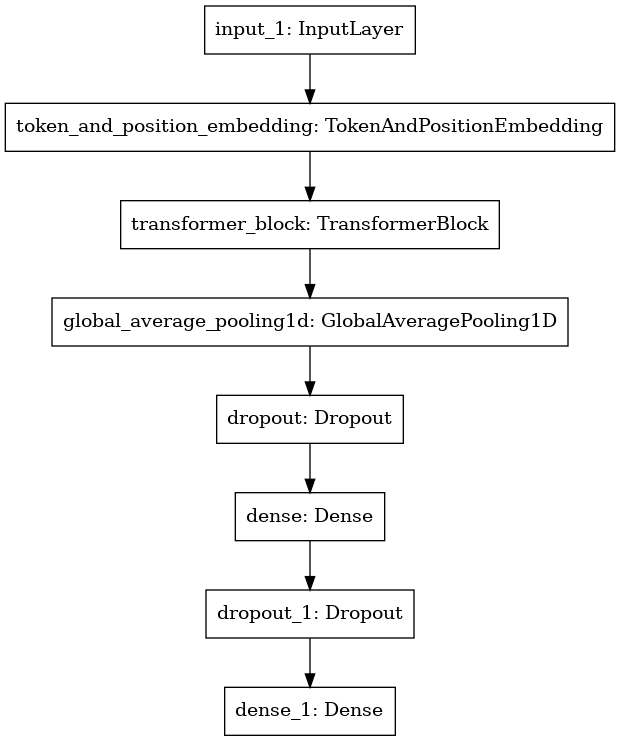

In [31]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [32]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.6161


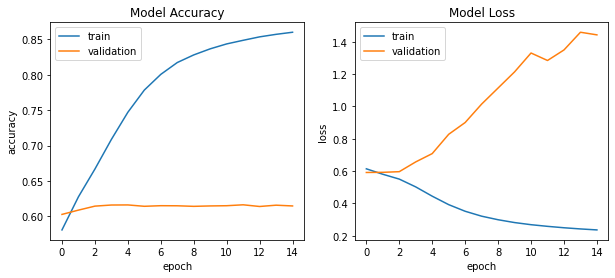

In [33]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(1,2, figsize=(10,4))
# first plot
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train', 'validation'], loc='best')

# second plot
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['train', 'validation'], loc='best')

Text(51.0, 0.5, 'Predicted label')

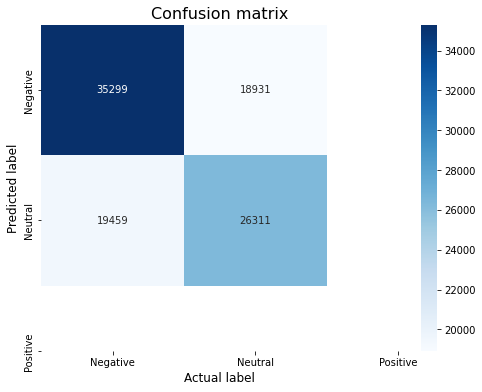

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
'''Function to plot confusion matrix for the passed model and the data'''

sentiment_classes = ['Negative','Neutral', 'Positive']
# use model to do the prediction
y_pred = model.predict(X_test)
# compute confusion matrix
cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

# plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)